# Exercises

## E01

Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

### Count Approach

In [19]:
import torch
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

Arrange counts as (27, 27, 27) tensor:

In [20]:
N = torch.zeros((27, 27, 27), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
      ix1 = stoi[ch1]
      ix2 = stoi[ch2]
      ix3 = stoi[ch3]
      #print('<', ch1, ix1,'>, <', ch2, ix2,'>, <', ch3, ix3, '>')
      N[ix1, ix2, ix3] += 1

Checking probabilities:

In [21]:
p = N[0, 1].float()
p = p / p.sum()
p
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
ix, itos[ix]

(12, 'l')

Constructing probability matrix:

In [22]:
P = (N+1).float()
P /= P.sum(2, keepdim=True)
assert P[0, 0].sum() == 1

In [23]:
P.shape

torch.Size([27, 27, 27])

Sampling:

In [24]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
  out = []
  # two starting chars
  ix1 = 0
  ix2 = 0
  while True:
      p = P[ix1, ix2] # prob vector of (ix1, ix2)
      
      # move chars along until we hit 0
      ix1 = ix2
      ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
      out.append(itos[ix2])
      if ix2 == 0:
          break
  print(''.join(out))

junide.
ilyasid.
prelay.
ocin.
fairritoper.
sathen.
dannaaryanileniassibduinrwin.
lessiyanayla.
te.
farmumthyfortumj.
ponn.
zena.
jaylicore.
ya.
zoffra.
jamilyn.
fmouis.
yah.
wanaasnhavi.
honszxhddion.


Calculate loss which is negative log likelihood:

In [25]:
n = 0
log_lh = 0.0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        
        prob = P[ix1, ix2, ix3]
        logprob = torch.log(prob)
        log_lh += logprob
        n += 1
        #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
        
print(f'{log_lh=}')
nll= - log_lh
print(f'{nll=}')
print(f'{nll/n}')

log_lh=tensor(-410414.9688)
nll=tensor(410414.9688)
2.092747449874878


**Loss is \~2 which is lower than bigram example of \~2.4**

*"What letter comes next after `.a`?"* is more precise than *"What letter comes next after `a`?"*

### NN Approach

In [26]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Create training set of trigrams, packing 1st and 2nd char as inputs and 3rd char as output:

In [27]:
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    xs.append((stoi[ch1], stoi[ch2]))
    ys.append(stoi[ch3])
    print(f'{ch1}[{stoi[ch2]}], {ch2}[{stoi[ch2]}], {ch3}[{stoi[ch3]}]')

    
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

.[5], e[5], m[13]
e[13], m[13], m[13]
m[13], m[13], a[1]
m[1], a[1], .[0]
number of examples:  8


One-hot encoding of examples:

In [28]:
xenc = F.one_hot(xs, num_classes=27)
print(xenc), xenc.shape

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]]])


(None, torch.Size([4, 2, 27]))

In [29]:
xs.shape, ys.shape

(torch.Size([4, 2]), torch.Size([4]))

See how we have to go into the second tensor of the 2nd training example? The second part should be combined, so we do that
(looked up at [Antimatter543/karpathy-NN-lectures](https://github.com/Antimatter543/karpathy-NN-lectures/blob/main/2%20-%20makemore/vid_exercises.ipynb))

In [30]:
xenc[1][1][stoi['m']]

tensor(1)

4 is because our example has 4 length — 1 less than bigrams for the same word (emma)

In [31]:
xenc = xenc.reshape(4, -1).float()
xenc.shape

torch.Size([4, 54])

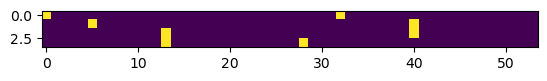

In [32]:
plt.imshow(xenc)

In [34]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27*2, 27), generator=g, requires_grad=True)

Manual forward pass:

In [52]:
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(4), ys].log().mean()
loss.item()

3.9894299507141113

In [49]:
W.grad = None
loss.backward()

In [50]:
W.data += -0.1 * W.grad

In [51]:
print(loss.item())

4.042260646820068


Loss is improving

Let's put everything together:

In [63]:
xs, ys = [], []

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    xs.append((stoi[ch1], stoi[ch2]))
    ys.append(stoi[ch3])
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27*2, 27), generator=g, requires_grad=True)

In [64]:
for k in range(100):
  xenc = F.one_hot(xs, num_classes=27)
  xenc = xenc.reshape(len(xenc), -1).float()

  logits = xenc @ W
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)
  loss = -probs[torch.arange(len(xenc)), ys].log().mean()
  
  print(loss.item())
  
  W.grad = None
  loss.backward()

  W.data += -50 * W.grad

4.186271667480469
3.3573689460754395
3.042151689529419
2.871455430984497
2.7671947479248047
2.6946818828582764
2.6390926837921143
2.5949816703796387
2.559002637863159
2.529222011566162
2.5042335987091064
2.483072519302368
2.464961051940918
2.4493141174316406
2.4356541633605957
2.423619031906128
2.412919759750366
2.4033381938934326
2.394700288772583
2.386871099472046
2.379739999771118
2.3732175827026367
2.3672289848327637
2.3617119789123535
2.3566133975982666
2.3518879413604736
2.34749698638916
2.343406915664673
2.3395884037017822
2.3360161781311035
2.332667589187622
2.3295230865478516
2.3265652656555176
2.3237788677215576
2.3211495876312256
2.3186655044555664
2.3163154125213623
2.314089059829712
2.3119773864746094
2.3099725246429443
2.3080661296844482
2.3062520027160645
2.3045237064361572
2.302875518798828
2.301301956176758
2.2997987270355225
2.298360824584961
2.2969841957092285
2.2956652641296387
2.294400691986084
2.293187141418457
2.2920210361480713
2.290900468826294
2.28982234001159

Seems like loss is a bit lower than bigram but not as low as count method 🤔

Sampling from net:

In [66]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
  
  out = []
  ix1, ix2 = 0, 0
  while True:
    xenc = F.one_hot(torch.tensor([ix1, ix2]), num_classes=27).float()
    xenc = xenc.reshape((1, -1))
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    
    ix1 = ix2
    ix2 = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix2])
    if ix2 == 0:
      break
  print(''.join(out))

aunide.
aliasad.
ushfay.
ainn.
aui.
ritoleras.
get.
adannaauranileniassibdainrwi.
ol.
seisiely.
